In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.anomaly.train_isolation_forest import train_isolation_forest, compute_anomaly_score
from uais.utils.metrics import compute_classification_metrics
from uais.utils.plotting import plot_roc_curve, plot_pr_curve


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [2]:
cyber_feats_path = project_root / 'data' / 'processed' / 'cyber' / 'unsw_nb15_features.parquet'
df_cyber = pd.read_parquet(cyber_feats_path)
print('Cyber features shape:', df_cyber.shape)

target_col = 'label'
X = df_cyber.drop(columns=[target_col])
y = df_cyber[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train:', X_train.shape, 'Test:', X_test.shape)
print('Attack ratio train/test:', y_train.mean(), y_test.mean())


Cyber features shape: (257673, 189)
Train: (206138, 188) Test: (51535, 188)
Attack ratio train/test: 0.6390767350027652 0.6390802367323178


In [3]:
iso_model, scaler = train_isolation_forest(
    X_train,
    random_state=42,
    contamination=0.03,
)

anomaly_scores_test = compute_anomaly_score(iso_model, scaler, X_test)
print('Anomaly scores min/max:', anomaly_scores_test.min(), anomaly_scores_test.max())


/opt/anaconda3/envs/ag311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/ag311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/ag311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Anomaly scores min/max: 0.0 1.0


Cyber anomaly-only metrics:
roc_auc: 0.5312
pr_auc: 0.6637
f1: 0.0205
precision: 0.5333
recall: 0.0104
accuracy: 0.3618


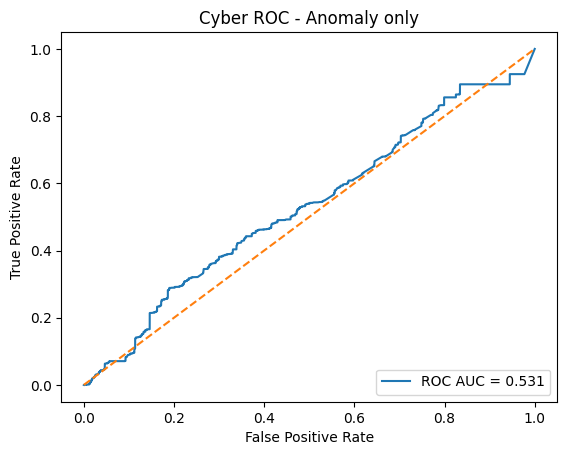

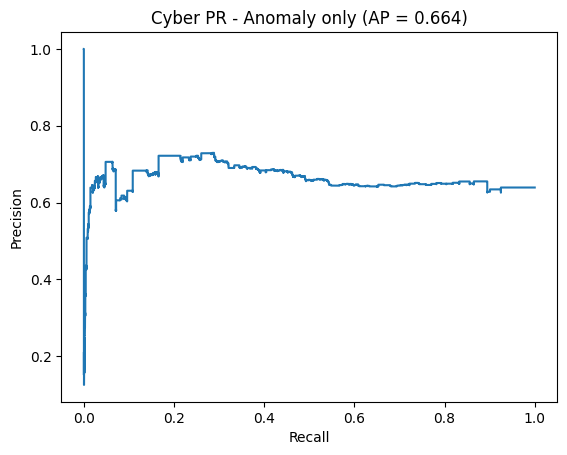

In [4]:
anomaly_metrics = compute_classification_metrics(y_test.values, anomaly_scores_test, threshold=0.5)

print('Cyber anomaly-only metrics:')
for k, v in anomaly_metrics.items():
    print(f"{k}: {v:.4f}")

plot_roc_curve(y_test.values, anomaly_scores_test, title='Cyber ROC - Anomaly only')
plot_pr_curve(y_test.values, anomaly_scores_test, title='Cyber PR - Anomaly only')
